# Can you help make sense of the Universe?



# Set up

#### Required Library

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features


#### Path

In [45]:
#data_folder = "/Users/youssefberrada/Downloads/all/"

# Data Acquisition

In [46]:

#train = pd.read_csv(data_folder+'training_set.csv')
#meta_train = pd.read_csv(data_folder+'training_set_metadata.csv')

In [47]:
data_folder = "/Users/youssefberrada/Documents/GitHub/PLAsTiCC-Astronomical-Classification/data/class_data/"
train = pd.read_csv(data_folder+'class_training_set.csv')
meta_train = pd.read_csv(data_folder+'class_training_set_meta.csv')

In [48]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,713,59825.2600,2,9.110147,1.013889,0
1,713,59825.2676,1,7.615042,1.160329,1
2,713,59825.2752,3,6.673631,1.932316,1
3,713,59825.2862,4,5.214194,3.018003,0
4,713,59825.2971,5,12.060948,7.163382,0


# Data Pre-Processing

In [49]:
fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],'kurtosis' : None, 'skewness' : None}
#fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],'kurtosis' : None, 'skewness' : None,'absolute_sum_of_changes':None,'ar_coefficient':[{'coeff': 1, 'k': 5},{'coeff': 2, 'k': 5},{'coeff': 3, 'k': 5},{'coeff': 4, 'k': 5},{'coeff': 5, 'k': 5}],'partial_autocorrelation':[{'lag':5}],'linear_trend':[{'attr':'slope'}],'fft_aggregated':[{'aggtype':'centroid'}],'sample_entropy':None,'abs_energy':None,'last_location_of_maximum':None,'last_location_of_minimum':None,}
def featurize(df):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # train[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]


    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew'],
    }

    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    # Add more features with 
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=5)
    df_det = df[df['detected']==1].copy()

    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = {'maximum':None, 'minimum':None}, n_jobs=5)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd,left_index=True, right_index=True)
    # tsfresh returns a dataframe with an index name='id'
    #agg_df_ts.index.rename('object_id',inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts,left_index=True, right_index=True)
    return agg_df
    #return agg_df_mjd,agg_df_ts


In [12]:
agg_train= featurize(train)


Feature Extraction: 100%|██████████| 25/25 [00:06<00:00,  4.64it/s]

Feature Extraction: 100%|██████████| 25/25 [00:00<00:00, 32.54it/s]

In [13]:
agg_train.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,...,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,mjd_diff_det
object_id,,,,,,,,,,,,,,,,,,,,,
713,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,...,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,846.8017
730,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,...,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352,78.7737
745,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,...,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857,123.6872
1124,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,...,3.603208,574.553907,524.107264,16.377058,3.904008,393.114268,357.907185,14.434470,3.657305,133.9113
1227,-12.695161,71.678154,0.367212,0.208109,4.962633,9.125056,0.720329,11.554160,2.596891,2.024407,...,-0.043294,30.384898,23.255760,3.266776,0.247423,25.692383,78.643093,1.290034,0.535841,691.9633


In [50]:
full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
train_mean = full_train.mean(axis=0)
full_train.fillna(0, inplace=True)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [51]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    return importances_

In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd

#modify to work with kfold
#def smoteAdataset(Xig, yig, test_size=0.2, random_state=0):
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):
    
        
    sm=SMOTE(random_state=2)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())

        
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [53]:
def lgbm_modeling_cross_validation(params,
                                   full_train, 
                                   y, 
                                   classes, 
                                   class_weights, 
                                   nr_fold=12, 
                                   random_state=1):

    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
   # print(weights)
   # weights=class_weights
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
        
                
        trn_xa, trn_y, val_xa, val_y=smoteAdataset(trn_x.values, trn_y.values, val_x.values, val_y.values)
        trn_x=pd.DataFrame(data=trn_xa, columns=trn_x.columns)
    
        val_x=pd.DataFrame(data=val_xa, columns=val_x.columns)
        
        clf = LGBMClassifier(**params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgbm_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        clfs.append(clf)

        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print('no {}-fold loss: {}'.format(fold_ + 1, 
              multi_weighted_logloss(val_y, oof_preds[val_, :], 
                                     classes, class_weights)))
    
        imp_df = pd.DataFrame({
                'feature': full_train.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_ + 1] * len(full_train.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = multi_weighted_logloss(y_true=y, y_preds=oof_preds, 
                                   classes=classes, class_weights=class_weights)
    print('MULTI WEIGHTED LOG LOSS: {:.5f}'.format(score))
    df_importances = save_importances(importances_=importances)
    df_importances.to_csv('lgbm_importances.csv', index=False)
    
    return clfs, score

# Data Analysis

#### Light GBM

In [54]:
lgb_params = {
            'device': 'cpu', 
            'objective': 'multiclass', 
            'num_class': 14, 
            'boosting_type': 'gbdt', 
            'n_jobs': -1, 
            'max_depth': 6, 
            'n_estimators': 1000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 5000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 1.0, 
            'cat_smooth': 59.5, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'multi_logloss', 
            'xgboost_dart_mode': False, 
            'uniform_drop': False, 
            'colsample_bytree': 0.5, 
            'drop_rate': 0.173, 
            'learning_rate': 0.025, 
            'max_drop': 5, 
            'min_child_samples': 10, 
            'min_child_weight': 200.0, 
            'min_split_gain': 0.01, 
            'num_leaves': 7, 
            'reg_alpha': 0.1, 
            'reg_lambda': 0.00023, 
            'skip_drop': 0.44, 
            'subsample': 0.75}

In [55]:
def multi_weighted_logloss(y_true, y_preds):
    """
    this function implements a multi logloss 
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False



In [56]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()


# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full_train.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0)

    clfs.append(clf)



Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.828923	training's wloss: 0.818871	valid_1's multi_logloss: 1.21254	valid_1's wloss: 1.14323
[200]	training's multi_logloss: 0.530926	training's wloss: 0.520064	valid_1's multi_logloss: 0.944242	valid_1's wloss: 0.91755
[300]	training's multi_logloss: 0.416988	training's wloss: 0.405939	valid_1's multi_logloss: 0.85276	valid_1's wloss: 0.866052
[400]	training's multi_logloss: 0.351845	training's wloss: 0.341113	valid_1's multi_logloss: 0.807067	valid_1's wloss: 0.853363
[500]	training's multi_logloss: 0.305525	training's wloss: 0.295485	valid_1's multi_logloss: 0.775945	valid_1's wloss: 0.847802
Early stopping, best iteration is:
[546]	training's multi_logloss: 0.288567	training's wloss: 0.278727	valid_1's multi_logloss: 0.764546	valid_1's wloss: 0.84661
0.8466102034007726
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.829118	training's wloss: 

In [57]:
def predict_chunk(df_, clfs_, meta_, features, train_mean):
    # Group by object id    
    agg_ = featurize(df_)
    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(0)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    #preds_99 = np.ones(preds_.shape[0])
    #for i in range(preds_.shape[1]):
    #    preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    #preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    return preds_df_

In [106]:

#meta_test = pd.read_csv(data_folder+'test_set_metadata.csv')
#meta_test = pd.read_csv(data_folder+'class_test_set_meta.csv')
#meta_test_full = pd.read_csv(data_folder+'class_test_set_meta.csv')
meta_test = pd.read_csv(data_folder+'class_test_set_meta.csv')
meta_test_full = pd.read_csv(data_folder+'class_test_set_meta.csv')

In [59]:
meta_test.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
2,2624,346.655182,-63.260487,320.952196,-50.040935,1,0.0000,0.0000,0.0000,NaN,0.019,65
3,2677,53.964844,-28.630989,225.142950,-53.813613,1,0.0000,0.0000,0.0000,NaN,0.009,16
4,3041,346.130127,-63.072620,321.423103,-50.042305,1,0.1069,0.1274,0.0198,38.8800,0.020,67


In [107]:

# meta_test.set_index('object_id',inplace=True)
import time

start = time.time()
chunks = 5000000
remain_df = None

for i_c, df in enumerate(pd.read_csv(data_folder+'class_test_set.csv', chunksize=chunks, iterator=True)):
    unique_ids = np.unique(df['object_id'])
    new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
    if remain_df is None:
        df = df.loc[df['object_id'].isin(unique_ids[:-1])]
    else:
        df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)
    # Create remaining samples df
    remain_df = new_remain_df
    preds_df = predict_chunk(df_=df,
                             clfs_=clfs,
                             meta_=meta_test,
                             features=full_train.columns,
                             train_mean=train_mean)

    if i_c == 0:
        preds_df.to_csv(data_folder+'predictions.csv', header=True, mode='a', index=False)
    else:
        preds_df.to_csv(data_folder+'predictions.csv', header=False, mode='a', index=False)

    del preds_df
    
    print('%15d done in %5.1f minutes' % (chunks * (i_c + 1), (time.time() - start) / 60), flush=True)

# Compute last object in remain_df
preds_df = predict_chunk(df_=remain_df,
                         clfs_=clfs,
                         meta_=meta_test,
                         features=full_train.columns,
                         train_mean=train_mean)

preds_df.to_csv(data_folder+'predictions.csv', header=False, mode='a', index=False)

/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """

Feature Extraction: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]

Feature Extraction: 100%|██████████| 25/25 [00:00<00:00, 38.42it/s]

        5000000 done in   0.4 minutes



Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 604.98it/s]

# Data Evaluation

### Loss Function 

# Data Presentation

### Confusion Matrix

### Plot the Confusion Matrix

Normalized confusion matrix


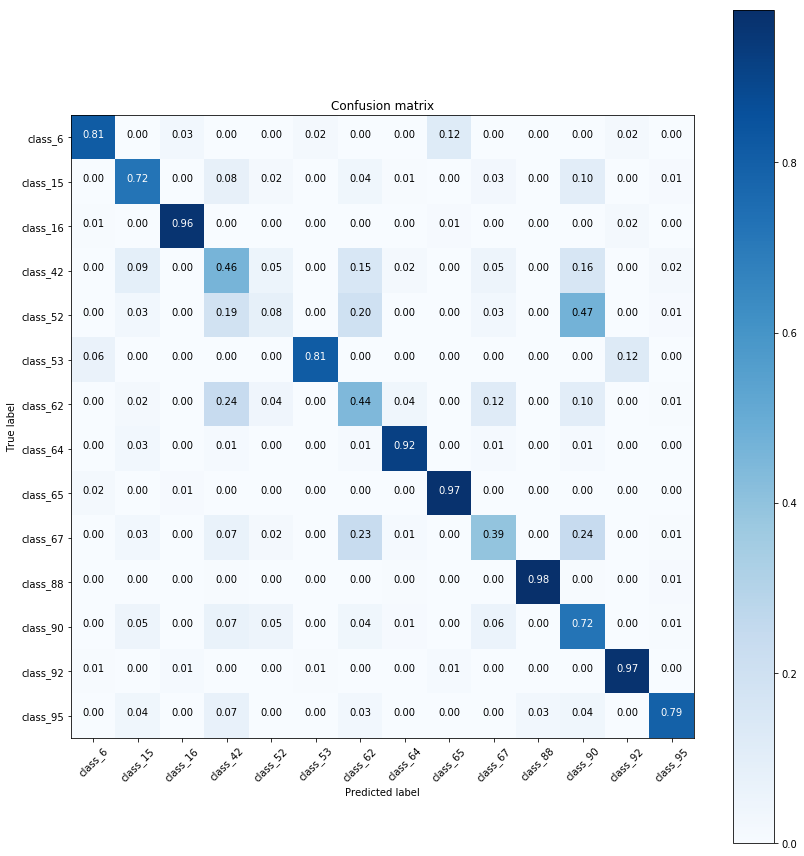

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

# Test Set Confusion Matrix

In [62]:
pred= pd.read_csv(data_folder+'predictions.csv')

In [63]:
pred.shape

(2590, 15)

In [64]:
y = np.array(meta_test_full.target)
unique_y =np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])



In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))

0.7633204633204633

In [32]:
accuracy_score(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))

0.7598455598455598

/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


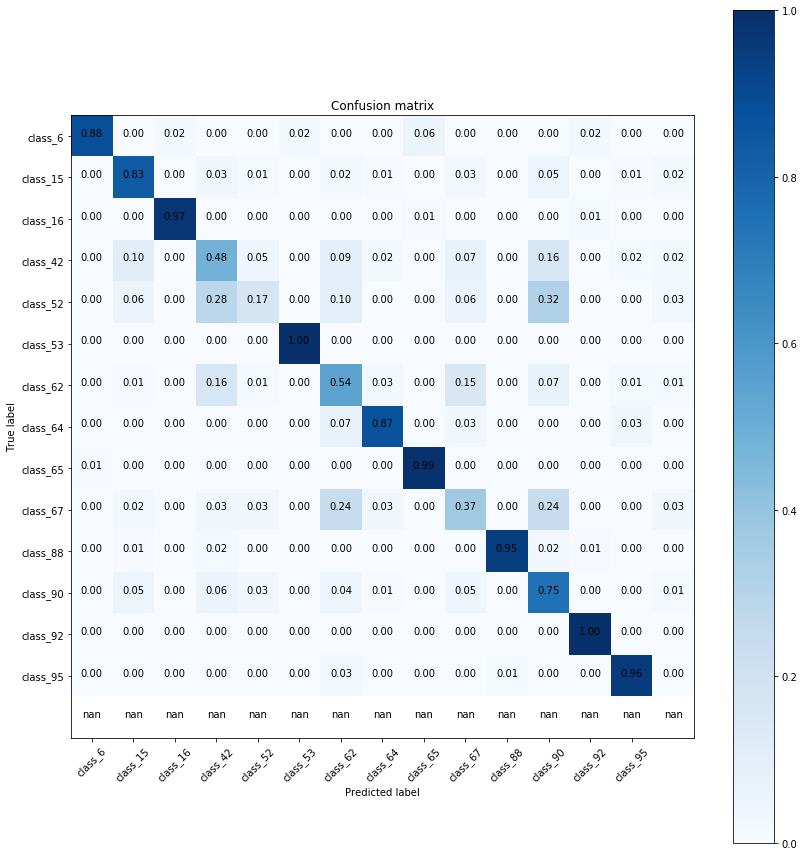

In [33]:
# Sheng Features
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/youssefberrada/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Normalized confusion matrix


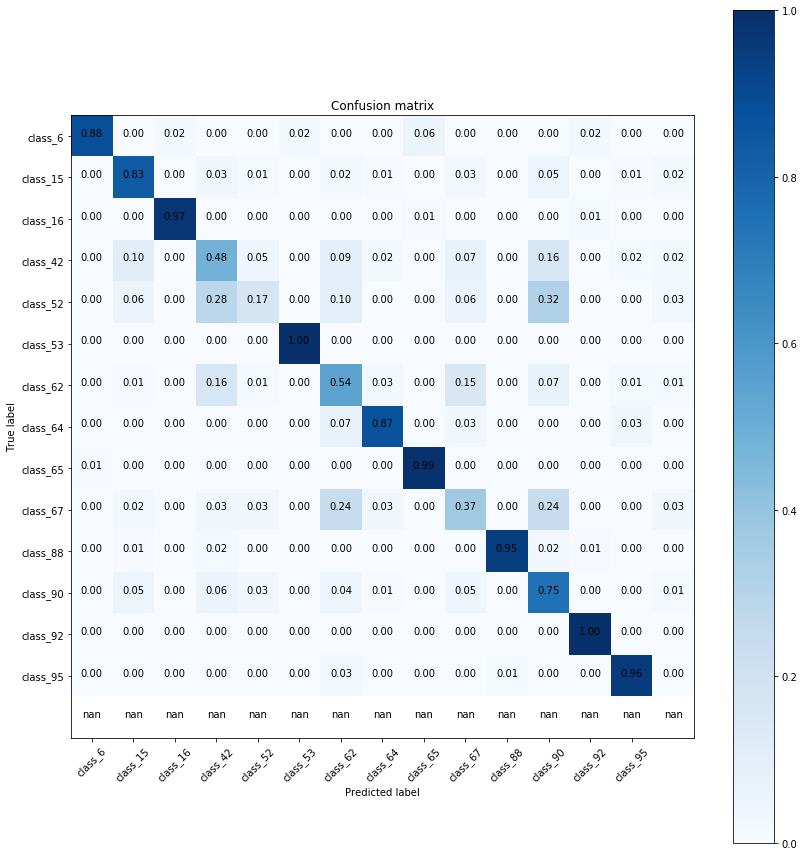

In [34]:
# Youssef's Features
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [35]:
opt = np.loadtxt('/Users/youssefberrada/Downloads/Opt_Tree_predict.txt')

Normalized confusion matrix


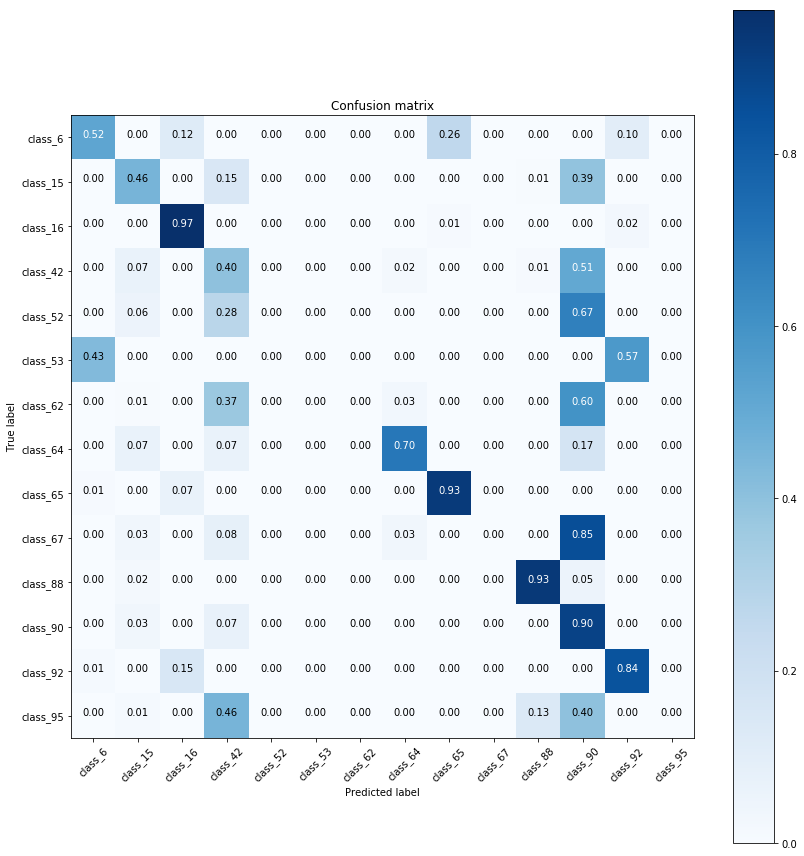

In [47]:
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(opt),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix


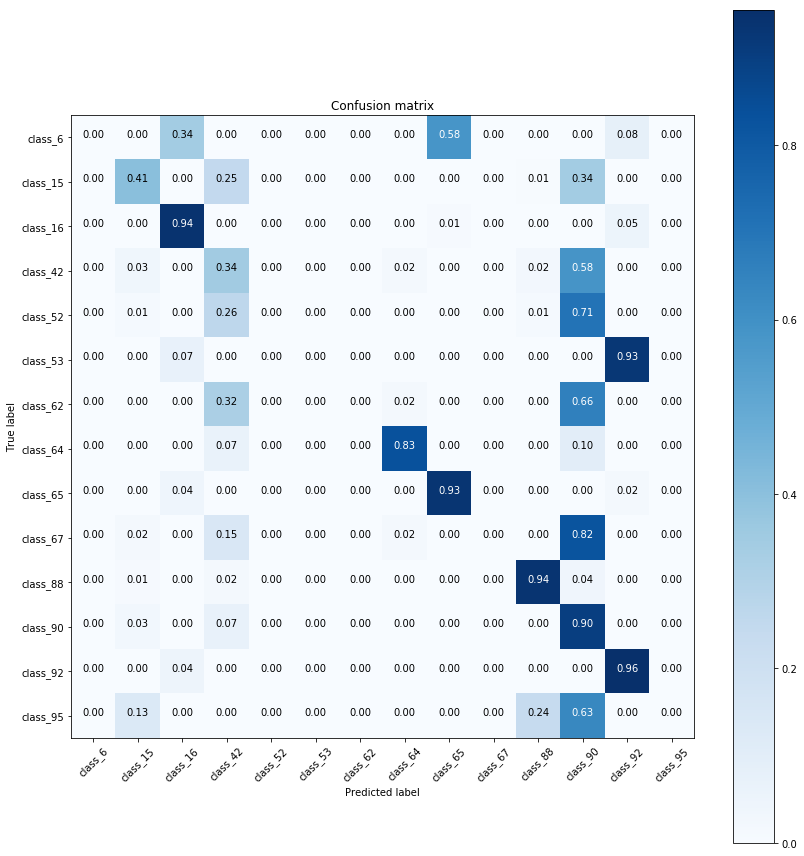

In [48]:
opt = np.loadtxt('/Users/youssefberrada/Downloads/predict.txt')
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(opt),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix


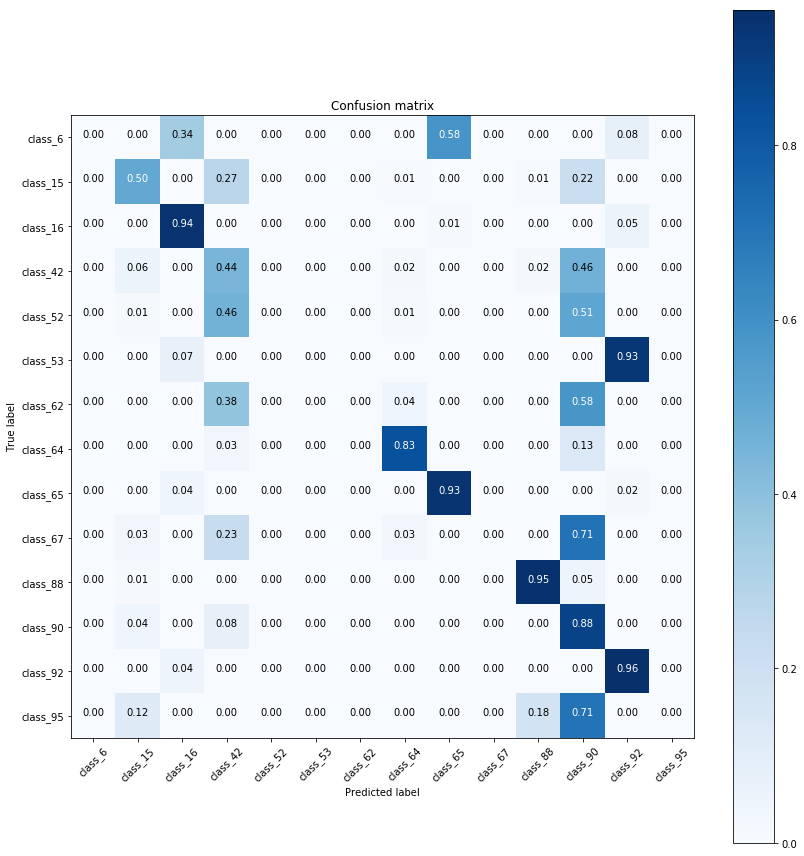

In [74]:
opt = np.loadtxt('/Users/youssefberrada/Downloads/predict_opt_h.txt')
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(opt),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [41]:
opt[1]

array([0.  , 0.08, 0.  , 0.16, 0.03, 0.  , 0.15, 0.  , 0.  , 0.05, 0.  ,
       0.51, 0.  , 0.01])

Normalized confusion matrix


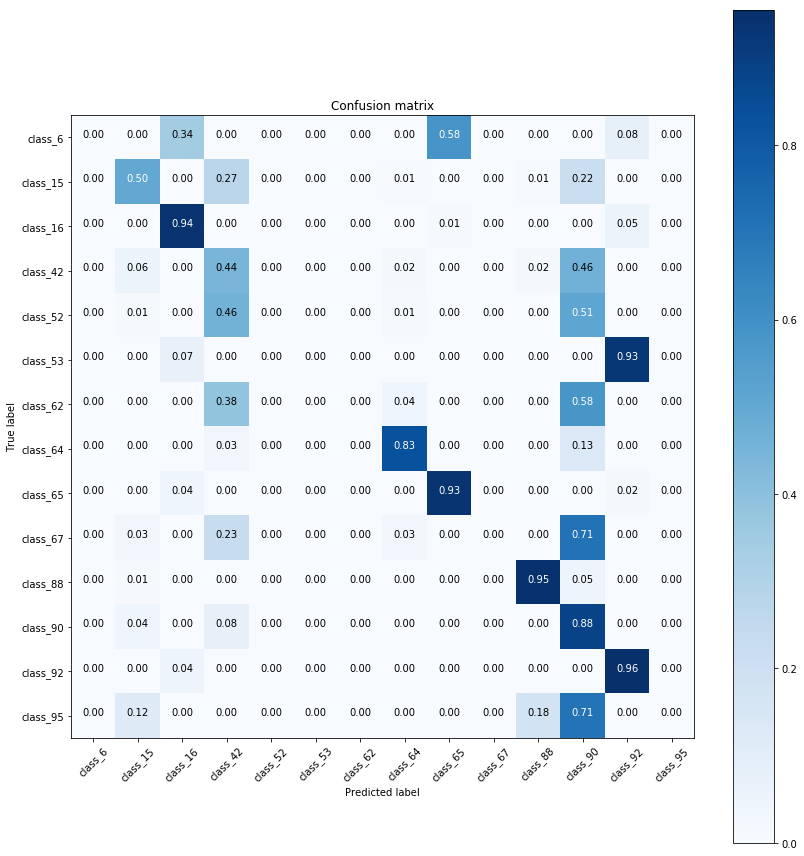

In [77]:
opt = np.loadtxt('/Users/youssefberrada/Downloads/predict_opt_h.txt')
opt = pd.DataFrame(opt).assign(object_id =pd.Series(pred.object_id).values)
opt.columns = pred.columns
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix


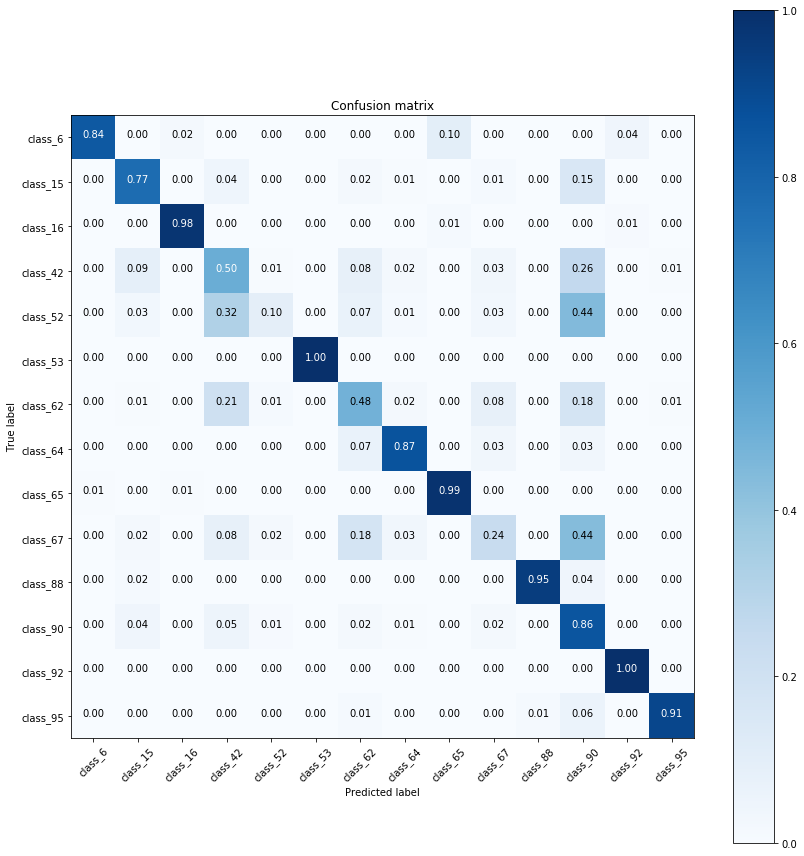

In [101]:
youssef = (0.7*pred+0.3*opt)/2
cnf_matrix = confusion_matrix(y_map, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [102]:
from sklearn.metrics import accuracy_score
accuracy_score(y_map, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))

0.7633204633204633

In [103]:
from sklearn.metrics import accuracy_score
accuracy_score(y_map, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1))

0.6710424710424711

In [104]:
from sklearn.metrics import accuracy_score
accuracy_score(y_map, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))

0.7822393822393823

In [105]:
1

1